<a href="https://colab.research.google.com/github/Walter45guru/pmct-Prevention-of-Mother-to-Child-Transmission-/blob/main/Electricity_consumption_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Electricity consumption and predicting


## necessary libraries

In [ ]:
# python
import datetime
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt

#Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


from prettytable import PrettyTable
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix
%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


## Load necessary data files


In [ ]:
# prompt: load datasets from my google drive

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assuming your dataset is in a CSV file named 'your_dataset.csv' in your Google Drive's 'My Drive' folder
file_path = '/content/drive/MyDrive/data science parctice/march madness/building_consumption_sub.csv'  # Replace 'your_dataset.csv' with the actual filename

# Load the dataset using pandas
building_df = pd.read_csv(file_path)
print("Dataset loaded successfully!")
    # Display the first few rows of the dataset
building_df.head()



Dataset loaded successfully!


,campus_id,meter_id,timestamp,consumption
0,1,39,2019-01-01 00:15:00,30.75
1,1,39,2019-01-01 00:30:00,31.25
2,1,39,2019-01-01 00:45:00,30.50
3,1,39,2019-01-01 01:00:00,30.25
4,1,39,2019-01-01 01:15:00,31.75


In [ ]:
# Assuming your dataset is in a CSV file named 'your_dataset.csv' in your Google Drive's 'My Drive' folder
file_path = '/content/drive/MyDrive/data science parctice/march madness/nmi_consumption_sub.csv'  # Replace 'your_dataset.csv' with the actual filename

# Load the dataset using pandas
NMI_df = pd.read_csv(file_path)
print("NMI electricity consumption data"
"This repository contains subset of electricity consumption data of #5 NMI in 2019!")
    # Display the first few rows of the dataset
NMI_df.head()


NMI electricity consumption dataThis repository contains subset of electricity consumption data of #5 NMI in 2019!


,campus_id,meter_id,timestamp,consumption,demand_kW,demand_kVA
0,1.0,5,2019-01-01 00:00:00,8.512,34.048,34.048
1,1.0,5,2019-01-01 00:15:00,7.648,30.592,30.592
2,1.0,5,2019-01-01 00:30:00,7.584,30.336,30.336
3,1.0,5,2019-01-01 00:45:00,7.712,30.848,30.848
4,1.0,5,2019-01-01 01:00:00,7.616,30.464,30.464


In [ ]:
file_path = '/content/drive/MyDrive/data science parctice/march madness/weather_data_sub_1.csv'  # Replace 'your_dataset.csv' with the actual filename

# Load the dataset using pandas
weather_df = pd.read_csv(file_path)
print("Weather Dataset loaded successfully!")
    # Display the first few rows of the dataset
weather_df.head()

Weather Dataset loaded successfully!


,campus_id,timestamp,apparent_temperature,relative_humidity,wind_speed,wind_direction
0,1,2019-01-01 00:00:00,15.9,68.0,9.4,196.0
1,1,2019-01-01 00:01:00,15.8,68.0,9.4,203.0
2,1,2019-01-01 00:02:00,15.8,69.0,9.4,210.0
3,1,2019-01-01 00:03:00,16.2,69.0,7.6,219.0
4,1,2019-01-01 00:04:00,15.6,69.0,11.2,207.0


<Axes: xlabel='timestamp'>

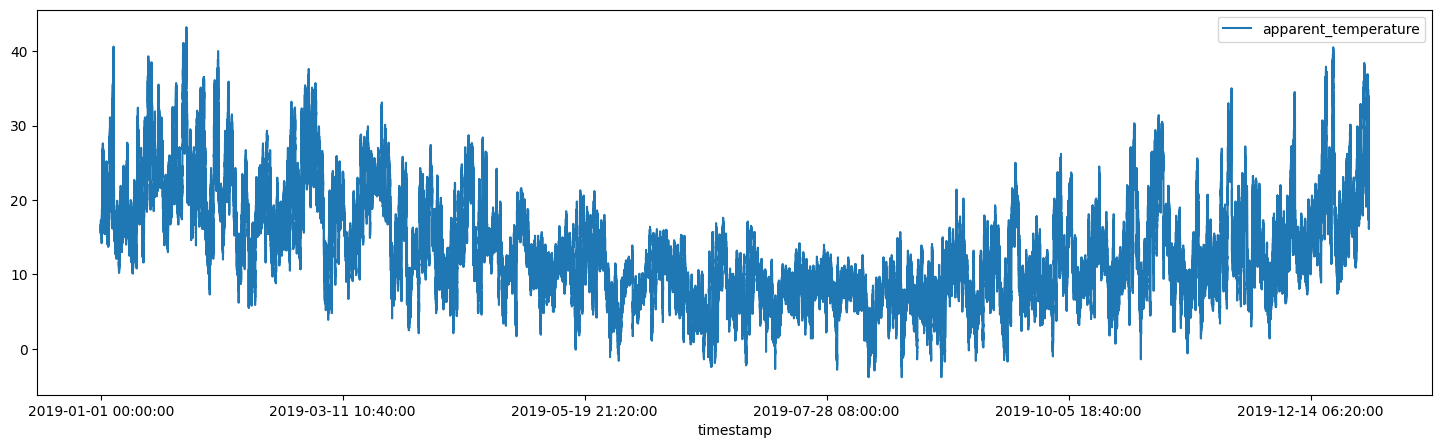

In [ ]:
weather_df[["timestamp", "apparent_temperature"]].plot(x="timestamp", y="apparent_temperature")

<Axes: xlabel='timestamp'>

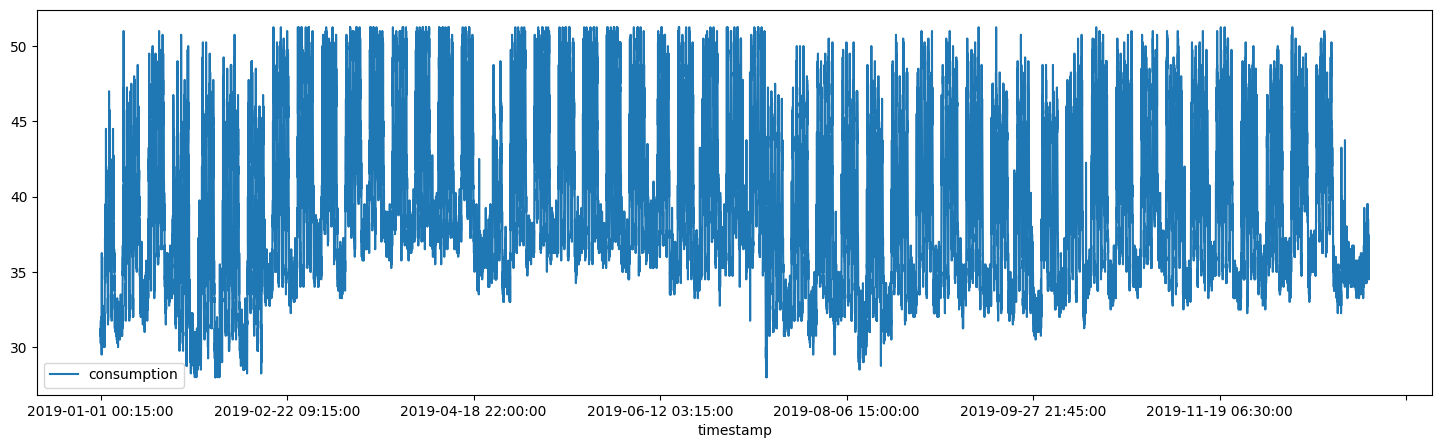

In [ ]:
building_df.plot(x="timestamp", y="consumption")

### Merging datasets  building_df and weather_df


In [ ]:
df_merge = pd.merge(building_df, weather_df, on='timestamp', how='left')
df_merge.head()

,campus_id_x,meter_id,timestamp,consumption,campus_id_y,apparent_temperature,relative_humidity,wind_speed,wind_direction
0,1,39,2019-01-01 00:15:00,30.75,1.0,16.2,71.0,7.6,203.0
1,1,39,2019-01-01 00:30:00,31.25,1.0,16.1,73.0,7.6,216.0
2,1,39,2019-01-01 00:45:00,30.50,1.0,15.6,76.0,9.4,218.0
3,1,39,2019-01-01 01:00:00,30.25,1.0,16.3,77.0,5.4,230.0
4,1,39,2019-01-01 01:15:00,31.75,1.0,17.3,78.0,0.0,237.0


In [ ]:
#Convert timestamp in to time object
df_merge['timestamp'] = pd.to_datetime(df_merge['timestamp'])
# Add hour as a feature from timestamp
df_merge['hour'] = df_merge.timestamp.dt.hour
# Add minutes feature from timestamp
df_merge['minutes'] = df_merge.timestamp.dt.minute

In [ ]:
# Add a feature to indicate whether given day is a weekend or not
df_merge["is_weekend"] = df_merge.timestamp.dt.day_name().isin(['Saturday', 'Sunday'])
df_merge["is_weekend"] = df_merge["is_weekend"].astype(int)

In [ ]:
#drop missing value
df_merge = df_merge.dropna()
df_merge.isnull().sum()

,0
campus_id_x,0
meter_id,0
timestamp,0
consumption,0
campus_id_y,0
apparent_temperature,0
relative_humidity,0
wind_speed,0
wind_direction,0
hour,0


In [ ]:
df_merge.dtypes

,0
campus_id_x,int64
meter_id,int64
timestamp,datetime64[ns]
consumption,float64
campus_id_y,float64
apparent_temperature,float64
relative_humidity,float64
wind_speed,float64
wind_direction,float64
hour,int32


In [ ]:
# Kenyan grid emission factor (kg CO2 per kWh)
EMISSION_FACTOR = 0.309  # Update this value if needed for your use case
df_merge['carbon_footprint'] = df_merge['consumption'] * EMISSION_FACTOR

# Optional: Round to 3 decimal places for readability
df_merge['carbon_footprint'] = df_merge['carbon_footprint'].round(3)
df_merge.head()

,campus_id_x,meter_id,timestamp,consumption,campus_id_y,apparent_temperature,relative_humidity,wind_speed,wind_direction,hour,minutes,is_weekend,carbon_footprint
0,1,39,2019-01-01 00:15:00,30.75,1.0,16.2,71.0,7.6,203.0,0,15,0,9.502
1,1,39,2019-01-01 00:30:00,31.25,1.0,16.1,73.0,7.6,216.0,0,30,0,9.656
2,1,39,2019-01-01 00:45:00,30.50,1.0,15.6,76.0,9.4,218.0,0,45,0,9.424
3,1,39,2019-01-01 01:00:00,30.25,1.0,16.3,77.0,5.4,230.0,1,0,0,9.347
4,1,39,2019-01-01 01:15:00,31.75,1.0,17.3,78.0,0.0,237.0,1,15,0,9.811


In [ ]:
df_merge.drop(columns=['campus_id_x', 'meter_id', 'campus_id_y'], inplace=True)

###Electricity consumption often depends on past values.

In [ ]:
df_merge['consumption_lag1'] = df_merge['consumption'].shift(1)  # Previous hour's consumption
df_merge['consumption_lag2'] = df_merge['consumption'].shift(2)  # 2 hours before
df_merge['consumption_lag24'] = df_merge['consumption'].shift(24)  # Same time yesterday


In [ ]:
df_merge['hour_sin'] = np.sin(2 * np.pi * df_merge['hour'] / 24)  # Convert hour into cyclical feature
df_merge['hour_cos'] = np.cos(2 * np.pi * df_merge['hour'] / 24)
df_merge['day_of_week'] = pd.to_datetime(df_merge['timestamp']).dt.dayofweek
df_merge['month'] = pd.to_datetime(df_merge['timestamp']).dt.month


Weekends may have different consumption patterns.


In [ ]:
df_merge['is_weekend'] = df_merge['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [ ]:
df_merge.columns

Index(['timestamp', 'consumption', 'apparent_temperature', 'relative_humidity',
       'wind_speed', 'wind_direction', 'hour', 'minutes', 'is_weekend',
       'carbon_footprint', 'consumption_lag1', 'consumption_lag2',
       'consumption_lag24', 'hour_sin', 'hour_cos', 'day_of_week', 'month'],
      dtype='object')

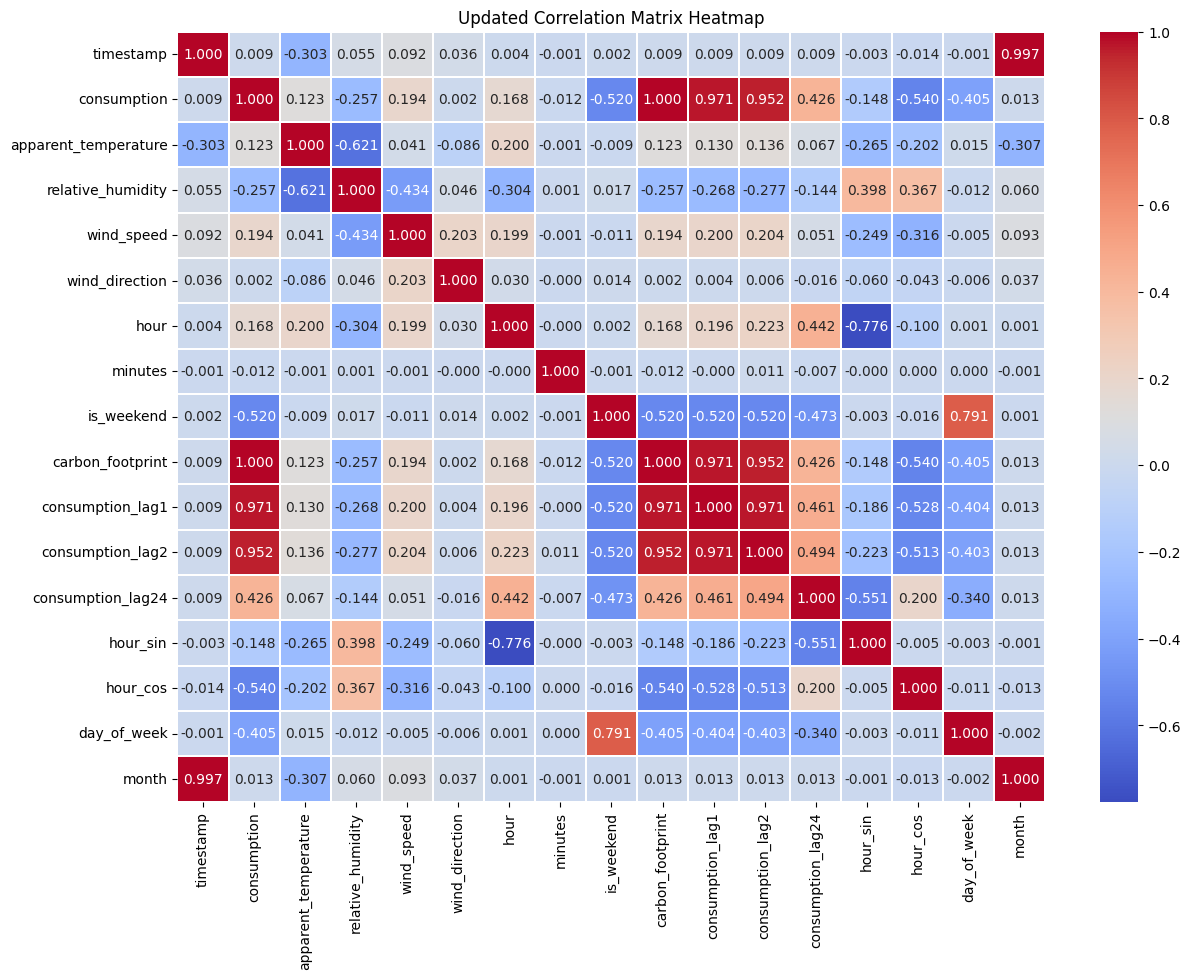

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute new correlation matrix
corr_matrix = df_merge.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.2)
plt.title("Updated Correlation Matrix Heatmap")
plt.show()


##### Checking for Multicollinearity with VIF

VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity. A VIF value above 5 or 10 is typically a red flag. For predicting electricity consumption, you'll ideally want most of your features to have VIF values under 5, so that they contribute independent information.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assume 'df_merge' is your DataFrame
# Let's define a new list of features that excludes the problematic ones:
# Drop 'consumption' (if it's the target) and 'carbon_footprint' (if it's almost identical to consumption)
# Also drop high-VIF lag features (consumption_lag1 and consumption_lag2) and possibly 'temp_wind_speed'
selected_features = [
    'apparent_temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
     'minutes', 'is_weekend', 'consumption_lag24',
    'hour_sin', 'hour_cos', 'day_of_week', 'month'
]

# Prepare the predictors DataFrame (ensure to drop any missing values)
X_new = df_merge[selected_features].dropna()

# Add a constant term for the intercept (needed for VIF calculation)
X_new = pd.concat([pd.Series(1, index=X_new.index, name='Intercept'), X_new], axis=1)

# Calculate the VIF for each feature in the adjusted set
vif_data_new = pd.DataFrame()
vif_data_new["Feature"] = X_new.columns
vif_data_new["VIF"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif_data_new)


                 Feature         VIF
0              Intercept  228.037609
1   apparent_temperature    2.056976
2      relative_humidity    2.559691
3             wind_speed    1.533746
4         wind_direction    1.076432
5                minutes    1.000128
6             is_weekend    3.376812
7      consumption_lag24    2.343249
8               hour_sin    2.024736
9               hour_cos    1.320546
10           day_of_week    2.698109
11                 month    1.141196


In [ ]:


# Assume 'df_merge' is your DataFrame containing all the data.
# List of features based on your VIF analysis:
selected_features = [
    'apparent_temperature', 'relative_humidity', 'wind_speed', 'wind_direction',
    'minutes', 'is_weekend', 'consumption_lag24', 'hour_sin', 'hour_cos',
    'day_of_week', 'month'
]

# Define your predictors (X) and target variable (y).
# (Make sure your DataFrame includes a column for electricity consumption, e.g., 'consumption'.)
X = df_merge[selected_features].dropna()
y = df_merge['consumption'].loc[X.index]

# Split the data for evaluation (optional but recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the estimator
estimator = LinearRegression()

# Choose the number of features you want to select.
# For instance, let's select 7 features based on domain insight.
rfe = RFE(estimator, n_features_to_select=12)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the mask of selected features and ranking of all features
selected_mask = rfe.support_
feature_ranking = rfe.ranking_

print("RFE Feature Selection Results:")
for feature, selected, rank in zip(selected_features, selected_mask, feature_ranking):
    print(f"{feature}: selected = {selected}, rank = {rank}")

# Optionally, evaluate the model performance using only the selected features
selected_features_final = [feature for feature, sel in zip(selected_features, selected_mask) if sel]
print("\nSelected Features:", selected_features_final)

# Train a new model using only the selected features
estimator.fit(X_train[selected_features_final], y_train)
y_pred = estimator.predict(X_test[selected_features_final])
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error with selected features: {mse:.2f}")


RFE Feature Selection Results:
apparent_temperature: selected = True, rank = 1
relative_humidity: selected = True, rank = 1
wind_speed: selected = True, rank = 1
wind_direction: selected = True, rank = 1
minutes: selected = True, rank = 1
is_weekend: selected = True, rank = 1
consumption_lag24: selected = True, rank = 1
hour_sin: selected = True, rank = 1
hour_cos: selected = True, rank = 1
day_of_week: selected = True, rank = 1
month: selected = True, rank = 1

Selected Features: ['apparent_temperature', 'relative_humidity', 'wind_speed', 'wind_direction', 'minutes', 'is_weekend', 'consumption_lag24', 'hour_sin', 'hour_cos', 'day_of_week', 'month']

Mean Squared Error with selected features: 8.69


### Data modelling

In [ ]:
# Selected features
features = [
    'apparent_temperature', 'relative_humidity', 'wind_speed',
    'wind_direction', 'minutes', 'is_weekend', 'consumption_lag24',
    'hour_sin', 'hour_cos', 'day_of_week', 'month'
]
target = 'consumption'


In [ ]:
# Load and preprocess data
data = df_merge[features + [target]].dropna()  # Clean missing values

# Split data (time-series split - don't shuffle!)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]


In [ ]:
# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target].values
y_test = test_data[target].values


In [ ]:
# Reshape data for LSTM (samples, timesteps, features)
def create_sequences(X, y, time_steps=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 24  # Adjust based on your data frequency
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

#### ANN Model

In [ ]:
def build_ann():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

ann_model = build_ann()
ann_history = ann_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5)],
    verbose=0
)

# Evaluate
y_pred_ann = ann_model.predict(X_test).flatten()
r2_ann = r2_score(y_test, y_pred_ann)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


####  LSTM Model

In [ ]:
def build_lstm():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[1])),
        Dropout(0.2),
        LSTM(30),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm()
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5)],
    verbose=0
)

# Evaluate
y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


####  Hybrid LSTM-ANN Model

In [ ]:
def build_hybrid():
    input_layer = Input(shape=(time_steps, X_train.shape[1]))
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = Dropout(0.2)(lstm)
    lstm = LSTM(32)(lstm)

    # ANN branch
    ann = Dense(32, activation='relu')(lstm)
    ann = Dropout(0.2)(ann)

    output = Dense(1)(ann)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

hybrid_model = build_hybrid()
hybrid_history = hybrid_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=5)],
    verbose=0
)

# Evaluate
y_pred_hybrid = hybrid_model.predict(X_test_seq).flatten()
r2_hybrid = r2_score(y_test_seq, y_pred_hybrid)

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


## Comparison & Visualization

             Model  R² Score
0              ANN  0.717041
1             LSTM -0.000006
2  Hybrid LSTM-ANN  0.656709


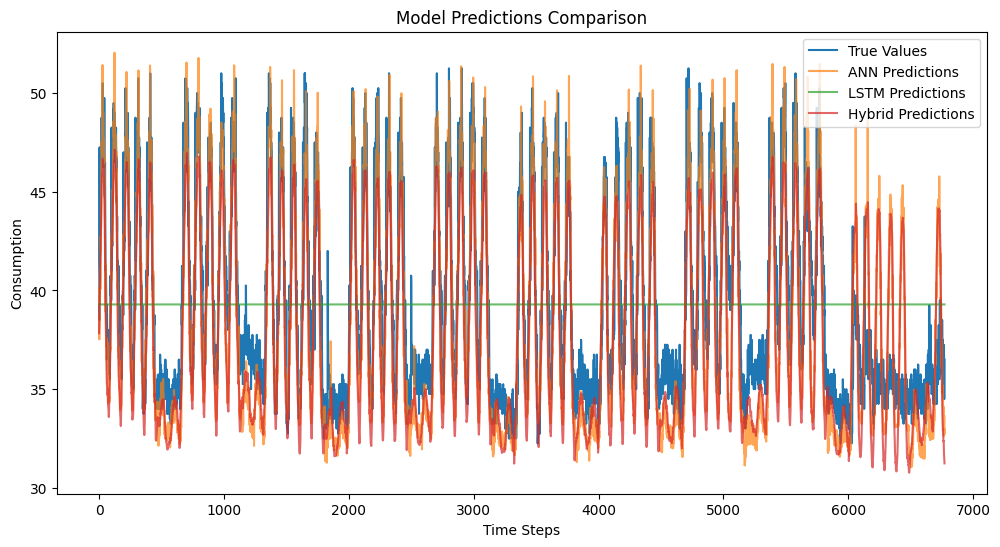

In [ ]:
import matplotlib.pyplot as plt

# Compare R² scores
results = pd.DataFrame({
    'Model': ['ANN', 'LSTM', 'Hybrid LSTM-ANN'],
    'R² Score': [r2_ann, r2_lstm, r2_hybrid]
})

print(results)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='True Values')
plt.plot(y_pred_ann[-len(y_test_seq):], label='ANN Predictions', alpha=0.7)
plt.plot(y_pred_lstm, label='LSTM Predictions', alpha=0.7)
plt.plot(y_pred_hybrid, label='Hybrid Predictions', alpha=0.7)
plt.title('Model Predictions Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Consumption')
plt.legend()
plt.show()